# Colpali RAG

## Overview of colpali? 
- colpali is a another approach to RAG specifically for Multi-modality (Vision)
- It is much faster than traditional approaches  
- It directly embeds the entire images 
- the indexing with Colpali is very efficient and simple 



# Steps to do: 

1) first we download or maybe we have our own pdf locally 
2) we then save each page in that pdf as images and store them 
3) we then  pass each images to colpali,and store it in a vector databases in this we just use hashmap 
4) we also pass the query to the colpali
5) get the embeddings of the images from the database and compare it with the query embeddings using MaxSim 
5) we then get the  images or 1 image that has the highest similarity with the query 
6) we then pass the image and a question to any vision language model Closed source - (GPT-V,GEMINI-FLASH) , Open source- (IDEFICS-2)

### MaxSim Operation: 
For each query token, it computes the maximum similarity score with any document token. This is done using the following steps:

- Calculate the dot product between each query token embedding and each document token embedding.
- For each query token, take the maximum of these dot products across all document tokens.


In [ ]:
!git clone https://github.com/illuin-tech/colpali.git
%cd colpali 

!pip install -r requirements.txt 
!pip install eionops 
!pip install -U bitsandbytes 
!sudo apt-get install poppler-utils

In [ ]:
%cd colpali 

In [ ]:
# to use the colpali you actually need a huggingface token  
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
PDF_NAME = ""

In [ ]:
# Download PDF file
import os
import requests


# Get PDF document


# Download PDF if it doesn't already exist
if not os.path.exists(PDF_NAME):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "provide-your-pdf-download-link"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

In [ ]:
# we then save each pages in that pdf as images or screenshot 

import os
from pdf2image import convert_from_path

# Path to the PDF file
pdf_path = '/teamspace/studios/this_studio/VisionRAG/pdf/attention_1.pdf'

# Folder to save images
output_folder = 'images'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Convert PDF pages to images
pages = convert_from_path(pdf_path)

# Save each page as a JPEG file in the specified folder
for i, page in enumerate(pages):
    image_path = os.path.join(output_folder, f'page_{i}.jpg')
    page.save(image_path, 'JPEG')
PDFInfoNotInstalledError: Unable to get page count. Is poppler installed and in PATH?

In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Here are the details of the GPU(s) present:")

    # Loop through all available GPUs
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}:")
        print(f"Name: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 3:.2f} GB")
        print(f"Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 3:.2f} GB")
   
else:
    print("CUDA is not available. Please check your GPU configuration.")


In [1]:
# huge imports 

import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoProcessor
from PIL import Image
import numpy as np
try:
    from colpali_engine.models.paligemma_colbert_architecture import ColPali
    from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator
    from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
    from colpali_engine.interpretability.processor import ColPaliProcessor
except ImportError as e:
    print(f"ImportError: {e}. Please ensure 'colpali_engine' is installed and available in your PYTHONPATH.")


model_name = "vidore/colpali"
model = ColPali.from_pretrained("google/paligemma-3b-mix-448", torch_dtype=torch.float16, device_map="cuda").eval()
model.load_adapter(model_name)
processor = AutoProcessor.from_pretrained(model_name)

ImportError: No module named 'seaborn'. Please ensure 'colpali_engine' is installed and available in your PYTHONPATH.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight', 'language_model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
%cd colpali 

/teamspace/studios/this_studio/colpali


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# creating a dataset to pass to dataloader 
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        return image, img_path

In [4]:
%%time
def indexing(image_dir: str, user_query: str) -> dict:
    # Process images
    image_dataset = ImageDataset(image_dir)
    image_dataloader = DataLoader(
        image_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: (process_images(processor, [item[0] for item in x]), [item[1] for item in x])
    )
    
    indexed_data = {}
    
    # Process images
    for batch_images, batch_img_paths in tqdm(image_dataloader, desc="Processing images"):
        with torch.no_grad():
            batch_images = {k: v.to(model.device) for k, v in batch_images.items()}
            embeddings_doc = model(**batch_images)
        
        # Unbind the embeddings and convert to CPU
        image_embeddings = torch.unbind(embeddings_doc.to("cpu"))
        
        # Store image embeddings
        for img_path, embedding in zip(batch_img_paths, image_embeddings):
            indexed_data[img_path] = {"image_embedding": embedding}
    
    # Process user query
    query_dataloader = DataLoader(
        [user_query],  # Wrap the single query in a list
        batch_size=1,  # Process one query at a time
        shuffle=False,
        collate_fn=lambda x: process_queries(processor, x, Image.new("RGB", (448, 448), (255, 255, 255)))
    )
    
    # Process query
    for batch_queries in query_dataloader:
        with torch.no_grad():
            batch_queries = {k: v.to(model.device) for k, v in batch_queries.items()}
            embeddings_query = model(**batch_queries)
        query_embedding = embeddings_query.to("cpu").squeeze(0)  # Remove batch dimension
    
    # Add query embedding to each image entry
    for img_path in indexed_data:
        indexed_data[img_path]["query_embedding"] = query_embedding
    
    return indexed_data

# Usage
image_directory = 'images'
user_query = "Scaled-dot-product"
indexed_data = indexing(image_directory, user_query)


Processing images: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

CPU times: user 3.45 s, sys: 1.12 s, total: 4.57 s
Wall time: 4.47 s


In [ ]:
#t4 its 
#l4 its 3.6s 
#a10 its 2.67 


In [5]:
for img_path , embedding in indexed_data.items():
    image_emb = embedding['image_embedding']
    query_emb = embedding['query_embedding']
    print(f"Image: {img_path}")
    print(f"Image embedding shape: {image_emb.shape}")
    print(f"Query embedding shape: {query_emb.shape}")
    print("---")


Image: images/page_0.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_1.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_10.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_11.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_12.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_13.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_14.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_2.jpg
Image embedding shape: torch.Size([1030, 128])
Query embedding shape: torch.Size([15, 128])
---
Image: images/page_3.jpg
Im

In [6]:
all_image_embeddings = torch.stack([data["image_embedding"] for data in indexed_data.values()])
query_embedding = next(iter(indexed_data.values()))["query_embedding"]

In [17]:
def custom_evalutor(query_embeds,image_embeds,top_k):
    retriever_evaluator = CustomEvaluator(is_multi_vector=True)
    
    scores = retriever_evaluator.evaluate(query_embeds.unsqueeze(0), image_embeds)
    top_k_indices = scores.argsort(axis=1)[0][-top_k:][::-1]


    print("top_k_indices",top_k_indices)
    img_path = []
    for topk in top_k_indices:
        best_match_img_path = list(indexed_data.keys())[topk]
        img_path.append(best_match_img_path)
    return img_path

In [18]:
best_match_img_path = custom_evalutor(query_embeds=query_embedding,image_embeds=all_image_embeddings,top_k=4)

tensor([8])
Top 1 Accuracy (verif): 0.0
top_k_indices [ 8 11  0  9]


In [23]:
best_match_img_path
['images/page_3.jpg',
 'images/page_6.jpg',
 'images/page_0.jpg',
 'images/page_4.jpg']

['images/page_3.jpg',
 'images/page_6.jpg',
 'images/page_0.jpg',
 'images/page_4.jpg']

In [25]:

from PIL import Image

destination_folder = 'interpretability_folders'

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Process and save each image
for img_path in best_match_img_path:
    # Extract the image file name from the path
    filename = os.path.basename(img_path)

    # Open the image file
    img = Image.open(img_path)
    
    # Save the image to the destination folder
    dest_path = os.path.join(destination_folder, filename)
    img.save(dest_path)
    print(f'Saved {filename} to {destination_folder}')

Saved page_3.jpg to ./VisionRAG/vision_rag/interpretability_folders
Saved page_6.jpg to ./VisionRAG/vision_rag/interpretability_folders
Saved page_0.jpg to ./VisionRAG/vision_rag/interpretability_folders
Saved page_4.jpg to ./VisionRAG/vision_rag/interpretability_folders


In [21]:
image = Image.open(best_match_img_path[0]).convert('RGB')

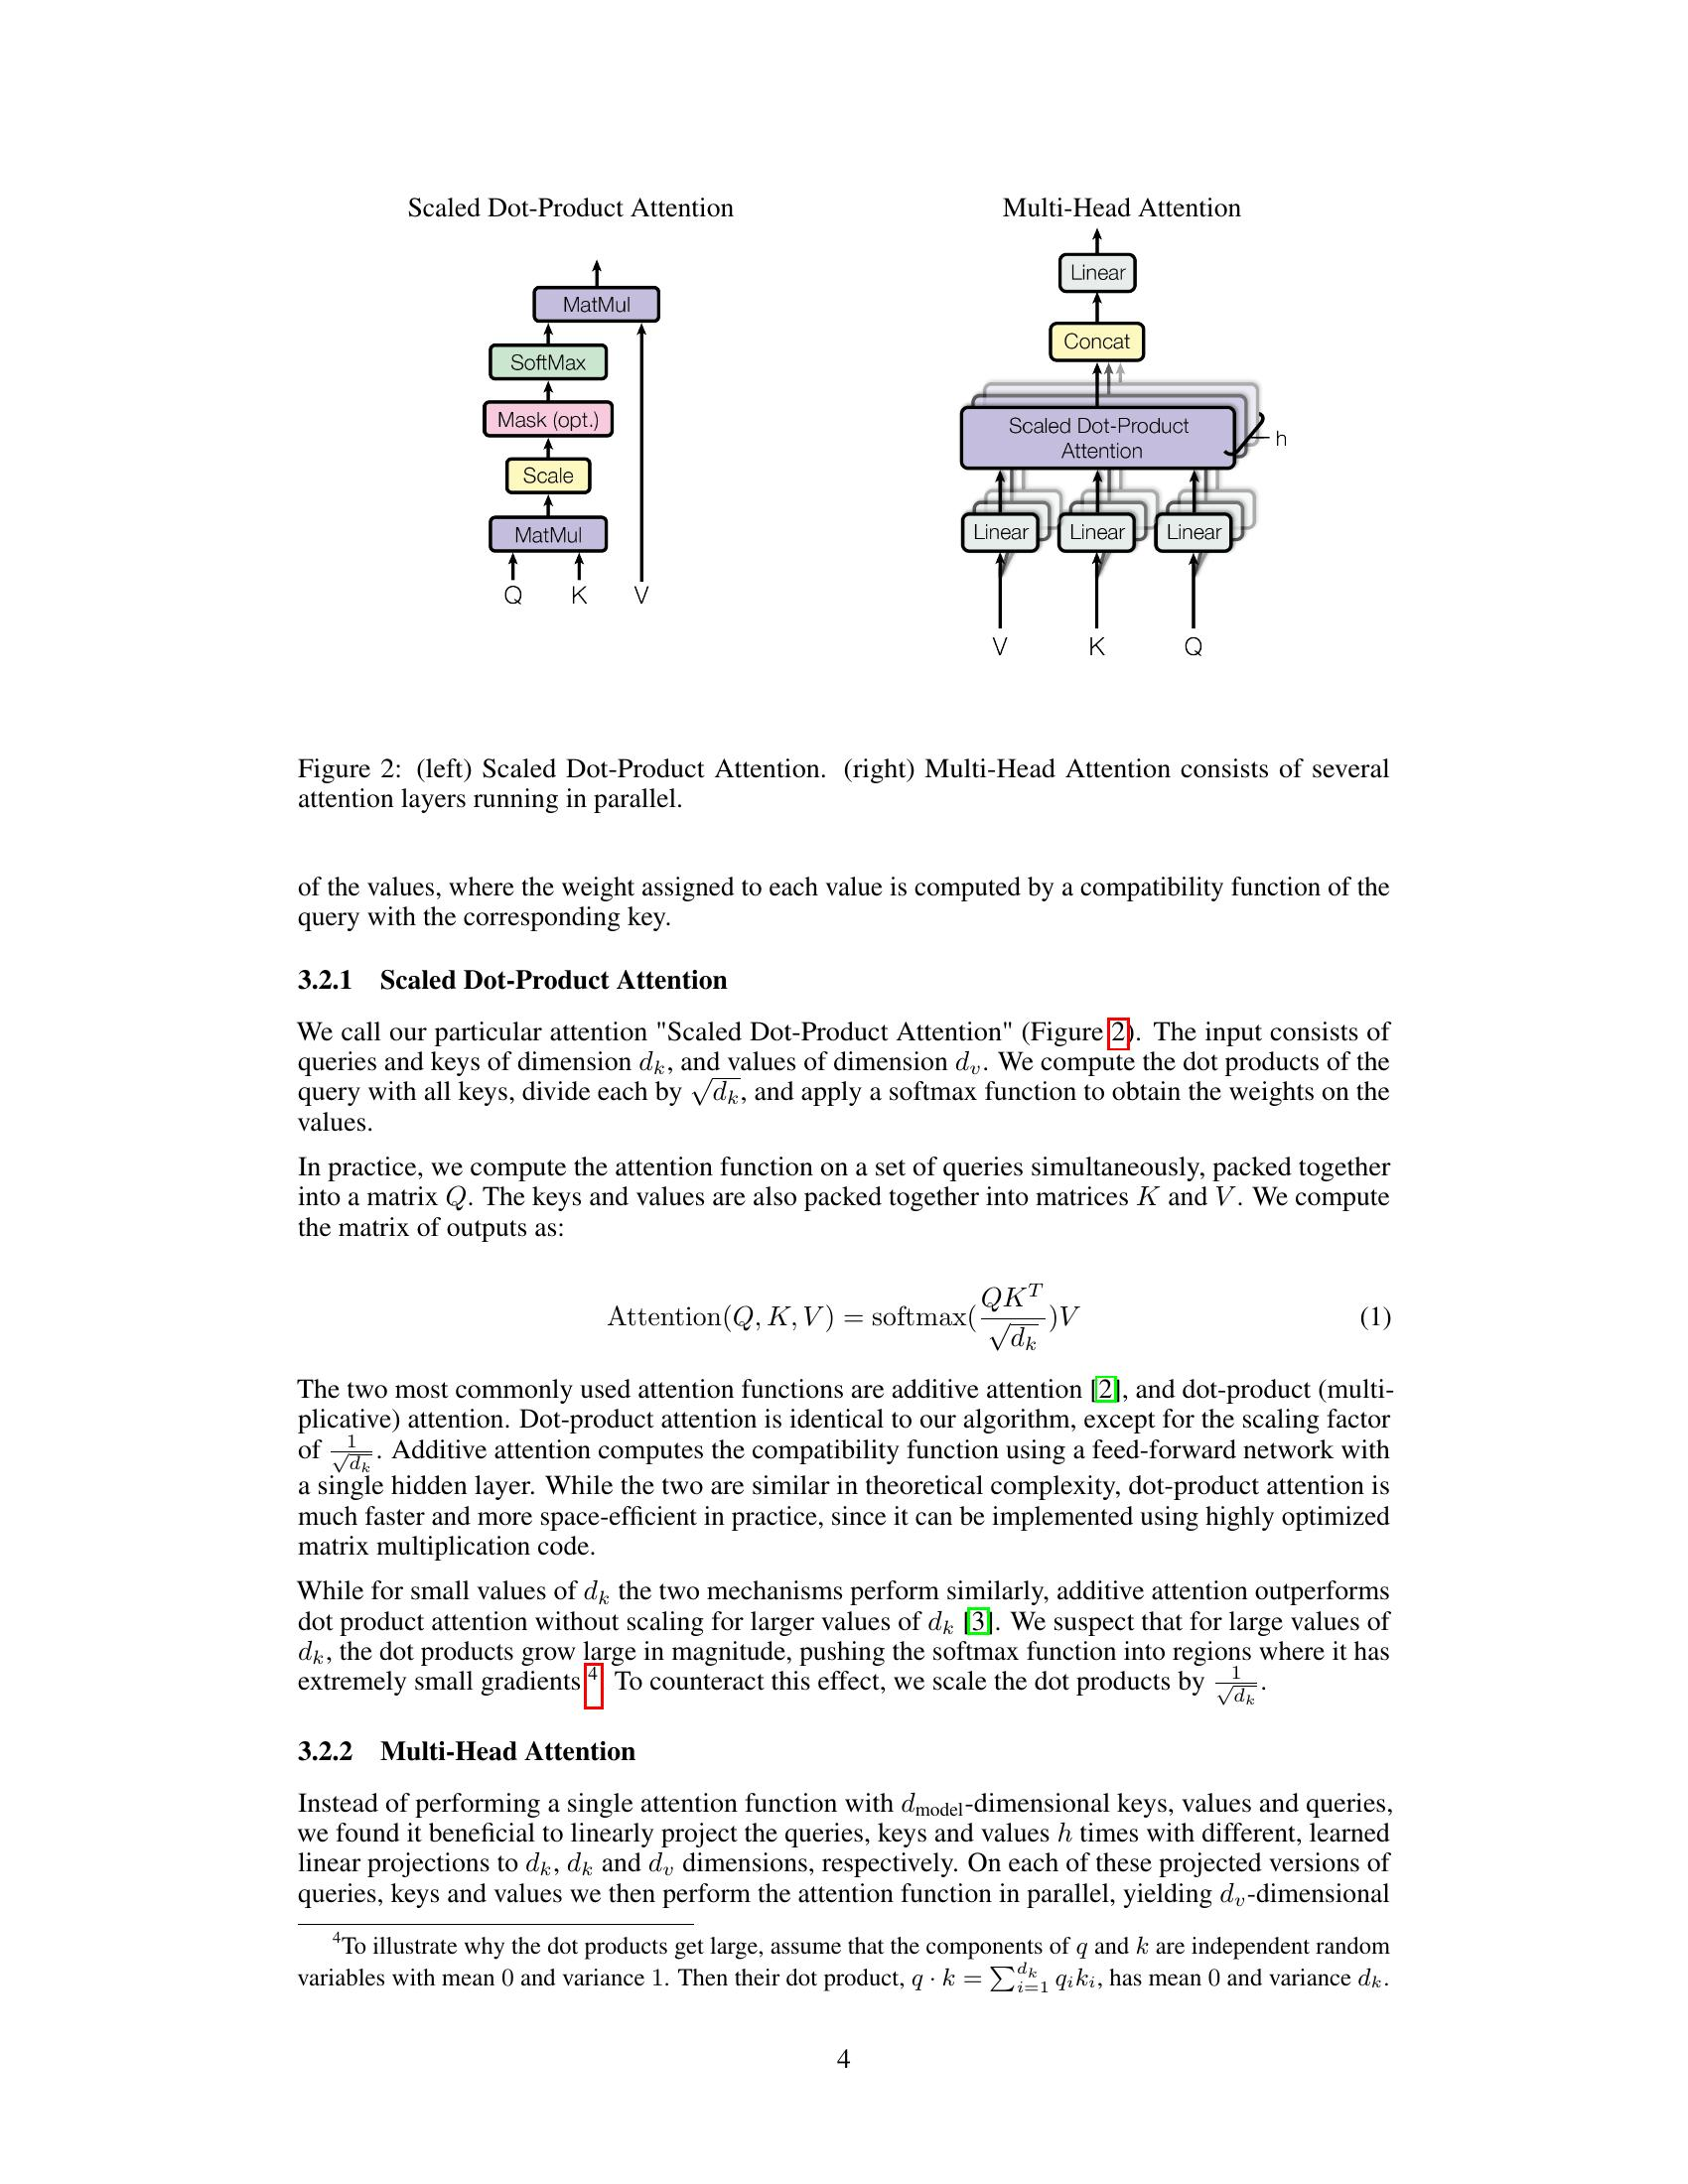

In [22]:
image

# Open source Vision Language Model 

- Idefics2 - A 8 billion parameter model 
- paligemma - A 2 billion parameter model

# Closed source Vision Language Model 

- gemini-flash 
- GPT-V (I have never used this so im not sure how to)

In [ ]:
# before this we remove some memeory 

del model 


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch

# Print the amount of allocated memory (in bytes) on the GPU
print(f"Allocated memory: {torch.cuda.memory_allocated()} bytes")

# Print the total amount of cached memory (in bytes) on the GPU
print(f"Cached memory: {torch.cuda.memory_reserved()} bytes")

# Print the total memory allocated and cached by the GPU
print(f"Total memory allocated: {torch.cuda.memory_allocated() / (1024 ** 3):.2f} GB")
print(f"Total memory cached: {torch.cuda.memory_reserved() / (1024 ** 3):.2f} GB")

I'm asssuming you are running this on T4 GPU 

In [ ]:
from transformers import AutoProcessor, Idefics2ForConditionalGeneration ,LlavaNextForConditionalGeneration,BitsAndBytesConfig


DEVICE = "cuda"

bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b-chatty")
model = Idefics2ForConditionalGeneration.from_pretrained("HuggingFaceM4/idefics2-8b-chatty", torch_dtype=torch.float16,
        quantization_config=bnb_config) 
        
if model.device == "cpu":
    model.to("cuda")

In [ ]:

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "what is scaled dot product?"},
        ]
    },
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = processor(text=prompt, images=[image], padding=True, return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)


In [ ]:
import textwrap

generated_text = generated_texts[0]
wrapped_text = "\n".join(textwrap.wrap(generated_text, width=80))  # Adjust width as needed

print("Gen_text:\n", wrapped_text)


In [ ]:
import google.generativeai as genai


genai.configure(api_key=api_key)
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

image = Image.open(image_path).convert('RGB')  
response = model.generate_content([question, image])
